# LAB: 9 Adversarial Attacks
"""
In this laboratory we will see a simple example of implementing adversarial attacks with the Adversarial Robustness Toolbox (ART) library in PyTorch. Check out their [GitHub repository](https://github.com/Trusted-AI/adversarial-robustness-toolbox) now to see how it works.

![Alt Text](https://github.com/Trusted-AI/adversarial-robustness-toolbox/raw/main/docs/images/art_lfai.png?raw=true)


In this laboratory, you will train a small model on the MNIST dataset. You will also do the following:

1. Test the trained model on adversarial examples Fast Gradient Descent Method (FGSM).
2. Train a new model with adversarial training strategy and compare the performance adversarially trained model on both original and adversarial data
4. Check the performance of both models against a new attack - Projected Gradient Descent (PGD).
5. Check model performance when varying the magnitude of the attack perturbation $ϵ = ||x_{adv} - x||$.  

We will use the ART classifier to train the model and make predictions.


In [ ]:
!pip install adversarial-robustness-toolbox

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist

## 0.1) Let's define the model and download the dataset
The parameters are chosen for reduced computational requirements of the script and not optimised for accuracy.


In [ ]:
# Define the neural network model, return logits instead of activation in forward method
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x


# Load the MNIST dataset
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Swap axes to PyTorch's NCHW format
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

# Create the model
model = Net()

## 0.2) Model traning
We will now train the ART classifier and evaluate it on the test set. The ART PytorchClassifier for  works similarly to a `sklearn`classifier with the `.fit()` and `.predict()` methods.


In [ ]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
batch_size = 64
n_epochs = 5
l_r = 0.001
optimizer = optim.AdamW(model.parameters(), lr=l_r)

# Create the ART classifier
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Train the ART classifier
classifier.fit(x_train, y_train, batch_size=batch_size, nb_epochs=n_epochs)

# Evaluate the ART classifier on benign test examples
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print(f"Accuracy on benign test examples: {accuracy * 100:.2f}%")

Accuracy on benign test examples: 98.58%


## 1) FGSM adversarial attack
Now it is up to you! You have to:
- Attack the trained model with an [FGSM attack](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#fast-gradient-method-fgm). Employ a maximum perturbation distance of $ϵ = 0.2$.  
- Compute the accuracy over the adversarial data and check whether it got reduced.
- Plot adversarial samples vs clean ones with the function below to check whether a human can notice the introduced noise

Accuracy on adversarial test examples: 22.01%


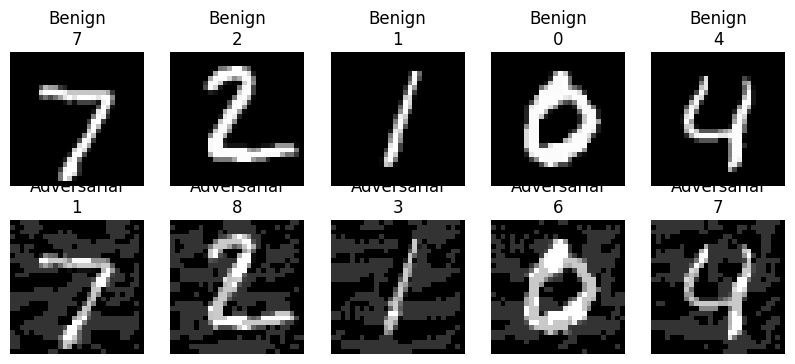

In [ ]:
import matplotlib.pyplot as plt
def plot_adv_samples(x_test, x_test_adv, predictions, predictions_adv):

    # Plot the first 5 benign and adversarial examples with their predictions
    n = 5
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Plot benign data
        plt.subplot(2, n, i + 1)
        plt.title(f"Benign\n{np.argmax(predictions[i])}")
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        # Plot adversarial data
        plt.subplot(2, n, n + i + 1)
        plt.title(f"Adversarial\n{np.argmax(predictions_adv[i + n])}")
        plt.imshow(x_test_adv[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

    plt.show()

eps = 0.2

# Generate adversarial test examples with the Fast Gradient Sign Method (FGSM) at epsilon = 0.2
# FILL IT YOURSELF: expected ~2 lines

# Evaluate the ART classifier on adversarial test examples
# FILL IT YOURSELF: expected ~3 lines

# Plot the adversarial samples vs clean ones together with their predictions
# FILL IT YOURSELF: expected ~1 line


## 2) Adversarial Training
Now let's see how to increase the robustness of the model. You have to:
1. Re-train the model with an augmented dataset equipped with both clean and adversarial samples. Use the [Adversarial Training](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/defences/trainer.html#adversarial-trainer) class for this. It returns a model that provide the standard `.fit()` and `.predict()` methods.
2. Check the accuracy of the new model on clean data
3. Check the accuracy of the new model on adversarial data.

*Note*: be aware that the classifier has to be **brand new**, not only  the ART PytorchClassifier, but also the underlying model and the associated optimizer

In [ ]:
from art.defences.trainer import AdversarialTrainer
from art.attacks.evasion import BasicIterativeMethod
# Train a new model on both adversarial and benign training examples
print("\nRetraining the model on both adversarial and benign training examples")
# FILL IT YOURSELF: expected ~10 lines

# Evaluate the new model on benign and adversarial test examples
# FILL IT YOURSELF: expected ~7 lines



Retraining the model on both adversarial and benign training examples


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy adv. trained model on benign examples: 97.71%
Accuracy adv. trained model on adversarial examples: 85.95%


##3) Check accuracy against a new attack: Projected Gradient Descent (PGD)
While the model seems to be more robust to FGSM attacks, it does not imply that the model is robust in general to any attacks! Let's check this by:
- Creating adversarial samples with PGD ($\epsilon=0.2$) for both the old and the new model
- Compute their accuracy over the new adversarial data

It should take about 1 min for each PGD attack on Google COLAB (expect more if you are running on your PC)

In [ ]:
# Evaluate the old and new model on a different attack (e.g., PGD) to check if the new model is more robust (always epsilon = 0.2)
# FILL IT YOURSELF: expected ~10 lines


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy clean model on PGD adversarial examples: 2.96%


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy adv. trained model on PGD adversarial examples: 47.69%


## 4) Evaluate both models at different attack magnitude
To provide a more extensive evaluation you have to test the robustness of your models at different magnitude values for the FGSM (and optionally PGD) attacks. Also plot the results of the accuracies at different values of $ϵ$. 4 lines expected:
 - Standard model - FGSM attack
 - Standard model - PGD attack (optional)
 - Robust model - FGSM attack
 - Robust model - PGD attack (optional)



Epsilon 0.0 - FGSM attack (standard model): 0.9858


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 0.0 - PGD attack (standard model): 0.9858
Epsilon 0.0 - FGSM attack (robust model): 0.9771


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 0.0 - PGD attack (robust model): 0.9771
Epsilon 0.1 - FGSM attack (standard model): 0.7457


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 0.1 - PGD attack (standard model): 0.647
Epsilon 0.1 - FGSM attack (robust model): 0.9513


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 0.1 - PGD attack (robust model): 0.9291
Epsilon 0.2 - FGSM attack (standard model): 0.2299


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 0.2 - PGD attack (standard model): 0.0296
Epsilon 0.2 - FGSM attack (robust model): 0.8764


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 0.2 - PGD attack (robust model): 0.4768
Epsilon 0.3 - FGSM attack (standard model): 0.0394


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 0.3 - PGD attack (standard model): 0.0091
Epsilon 0.3 - FGSM attack (robust model): 0.7028


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 0.3 - PGD attack (robust model): 0.03
Epsilon 0.4 - FGSM attack (standard model): 0.0145


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 0.4 - PGD attack (standard model): 0.0083
Epsilon 0.4 - FGSM attack (robust model): 0.3354


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 0.4 - PGD attack (robust model): 0.014
Epsilon 0.5 - FGSM attack (standard model): 0.0114


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 0.5 - PGD attack (standard model): 0.008
Epsilon 0.5 - FGSM attack (robust model): 0.1489


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 0.5 - PGD attack (robust model): 0.0131


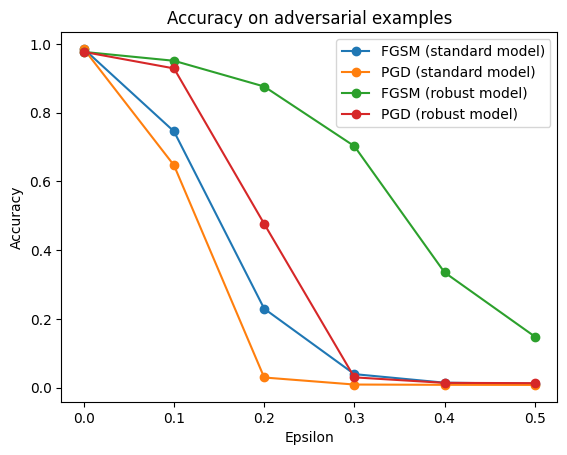

In [ ]:
# Evaluate both models at different epsilons for both FGSM and PGD and plot the results
epsilons = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
accuracies_fgsm = []
accuracies_pgd = []
accuracies_fgsm_adv = []
accuracies_pgd_adv = []

# FILL IT YOURSELF: expected ~25 lines


# plot the results
import matplotlib.pyplot as plt

plt.plot(epsilons, accuracies_fgsm, marker='o', label='FGSM (standard model)')
plt.plot(epsilons, accuracies_pgd, marker='o', label='PGD (standard model)')
plt.plot(epsilons, accuracies_fgsm_adv, marker='o', label='FGSM (robust model)')
plt.plot(epsilons, accuracies_pgd_adv, marker='o', label='PGD (robust model)')

plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy on adversarial examples')
plt.legend()

plt.show()

After this comprehensive analysis we have understood that:
- Adversarial attacks are a significant threat to deep learning models
- Even non-visible noise can drastically reduce model performance
- Adversarial training is very effective in increasing the robustness of the model
- Against different attacks, an adversarially trained model is still not sufficiently robust (even though more robust than a standard model)
- The ART library is an important resource to effectively apply and compare different attack and defense strategies